In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [81]:
class Encoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 2, 3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(2, 4, 3, stride=2, padding=1)
        self.fc = nn.Linear(4 * 7 * 7, latent_size)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 4 * 7 * 7)
        x = torch.sigmoid(self.fc(x))
        
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_size, 6 * 6)
        self.deconv1 = nn.ConvTranspose2d(1, 2, 3, stride=2)
        self.deconv2 = nn.ConvTranspose2d(2, 1, 3, stride=2, output_padding=1)
    
    def forward(self, x):
        x = F.relu(self.fc(x))
        x = x.view(-1, 1, 6, 6)
        x = F.relu(self.deconv1(x))
        x = torch.tanh(self.deconv2(x))
        return x

In [82]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        # x = x.view(-1, 28*28)
        h = self.E(x)
        out = self.D(h)
        return out
    
    def decode(self, h):
        with torch.no_grad():
            return self.D(h)
    
    def loss(self, x, target, **kwargs):
        # target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [83]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)}

train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [87]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [88]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l) + '\t'
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)


    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item()
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append((test_loss[k],))
    
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [89]:
for epoch in range(1, 21):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses 16: 0.755590 32: 0.424081 64: 0.755002
Train Epoch: 1 [10000/50000 (20%)]	Losses 16: 0.677028 32: 0.408097 64: 0.714212
Train Epoch: 1 [20000/50000 (40%)]	Losses 16: 0.625028 32: 0.418196 64: 0.677114
Train Epoch: 1 [30000/50000 (60%)]	Losses 16: 0.589492 32: 0.412262 64: 0.640500
Train Epoch: 1 [40000/50000 (80%)]	Losses 16: 0.543751 32: 0.392953 64: 0.599660
Train Epoch: 1 [50000/50000 (100%)]	Losses 16: 0.509427 32: 0.370194 64: 0.553390
Test set:
16: loss: 0.5175	
32: loss: 0.3825	
64: loss: 0.5579	

Train Epoch: 2 [0/50000 (0%)]	Losses 16: 0.544035 32: 0.412014 64: 0.568620
Train Epoch: 2 [10000/50000 (20%)]	Losses 16: 0.488147 32: 0.364475 64: 0.513730
Train Epoch: 2 [20000/50000 (40%)]	Losses 16: 0.481238 32: 0.374714 64: 0.489802
Train Epoch: 2 [30000/50000 (60%)]	Losses 16: 0.466129 32: 0.369730 64: 0.452803
Train Epoch: 2 [40000/50000 (80%)]	Losses 16: 0.454614 32: 0.367724 64: 0.431154
Train Epoch: 2 [50000/50000 (100%)]	Losses 16: 0.4592


Train Epoch: 16 [0/50000 (0%)]	Losses 16: 0.325976 32: 0.320730 64: 0.195510
Train Epoch: 16 [10000/50000 (20%)]	Losses 16: 0.338983 32: 0.334905 64: 0.200046
Train Epoch: 16 [20000/50000 (40%)]	Losses 16: 0.330428 32: 0.326894 64: 0.197147
Train Epoch: 16 [30000/50000 (60%)]	Losses 16: 0.320962 32: 0.317166 64: 0.199167
Train Epoch: 16 [40000/50000 (80%)]	Losses 16: 0.328277 32: 0.327419 64: 0.200248
Train Epoch: 16 [50000/50000 (100%)]	Losses 16: 0.334508 32: 0.333697 64: 0.199713
Test set:
16: loss: 0.3293	
32: loss: 0.3265	
64: loss: 0.1984	

Train Epoch: 17 [0/50000 (0%)]	Losses 16: 0.329623 32: 0.326078 64: 0.197195
Train Epoch: 17 [10000/50000 (20%)]	Losses 16: 0.335789 32: 0.334038 64: 0.199220
Train Epoch: 17 [20000/50000 (40%)]	Losses 16: 0.308259 32: 0.306252 64: 0.184557
Train Epoch: 17 [30000/50000 (60%)]	Losses 16: 0.305858 32: 0.302952 64: 0.188386
Train Epoch: 17 [40000/50000 (80%)]	Losses 16: 0.326080 32: 0.326378 64: 0.192550
Train Epoch: 17 [50000/50000 (100%)]	Loss

In [91]:
data, _ = next(iter(test_loader))
output = models['64'](data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = models['64'].decode(torch.eye(64))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = models['64'].E(data)
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = models['64'].decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([48, 53, 53, 58, 52, 57, 52, 53, 51, 56, 52, 57, 57, 54, 59, 50, 50, 47,
        49, 55, 56, 59, 53, 57, 54, 59, 51, 53, 56, 54, 55, 51, 53, 52, 53, 52,
        52, 55, 54, 60, 55, 54, 56, 50, 54, 55, 51, 51, 57, 50])


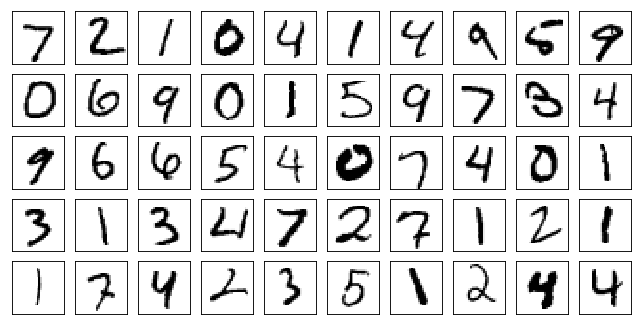

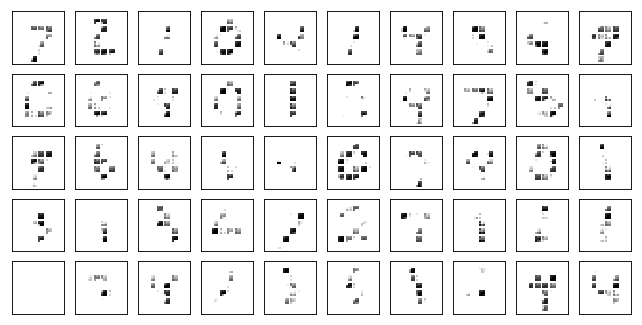

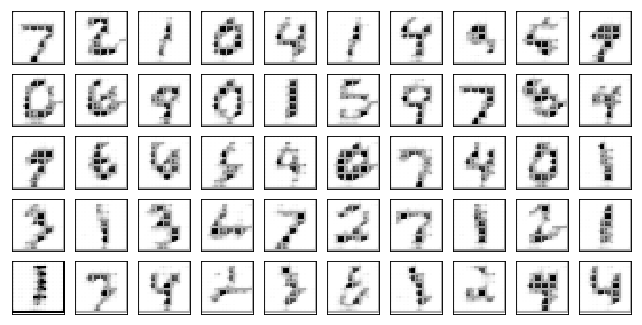

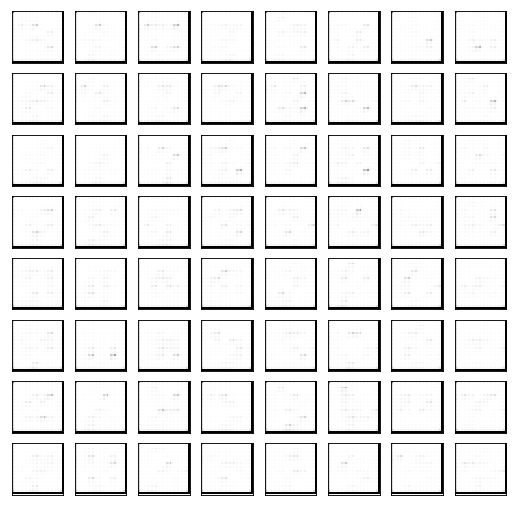

In [92]:
plot_mnist(data.data.numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_mnist(f_to_plot, (5, 10))
plot_mnist(dec_to_plot, (8, 8))